# Utilitários Unificados — Modelos, Datasets e Ruído

Este arquivo reúne três funções principais, com interface unificada e documentação clara:

1. `load_model_unificado(modelo, caminho, ...)`
   - Carrega qualquer modelo: `linear`, `mlp`, `lstm` (Keras) ou `tft` (PyTorch Forecasting).
   - Aceita arquivo/diretório EXATO ou uma pasta raiz para descoberta recursiva.

2. `dataset_loader_unificado(modelo, data_root, problema, split, ...)`
   - Carrega dados de qualquer modelo a partir de `data_root/problema`.
   - `linear/mlp/lstm` → TFRecords (TensorFlow).
   - `tft` → Parquet (padrão: retorna DataFrame; opcional: cria `TimeSeriesDataSet`).

3. `add_noise_features(obj, sigma, tipo, ...)`
   - Adiciona ruído GAUSSIANO somente nas FEATURES.
   - `tipo='tf_record'` → aplica em `tf.data.Dataset` (x,y).
   - `tipo='tft'` → aplica em batches de `TimeSeriesDataSet`/`DataLoader` (chaves `encoder_cont`/`decoder_cont`).

> Observação: Este notebook não executa comparações de performance — o foco aqui é a **integração**.

## 1) Carregamento Unificado de Modelos

Contrato rápido:
- Entradas:
  - `modelo`: `linear` | `mlp` | `lstm` | `tft`
  - `caminho`: arquivo/diretório exato OU uma pasta para varredura recursiva
  - `prefer_exts` (opcional): lista de extensões a priorizar (ex.: `[".cpfg", ".ckpt"]` para TFT)
  - `allow_unsafe` (bool): permite desserialização insegura apenas para artefatos LOCAIS (Lambda em Keras)
- Saídas: `(obj_modelo, info)`
  - `obj_modelo`: instancia do modelo carregado (Keras ou TemporalFusionTransformer)
  - `info`: dicionário com metadados úteis (`path`, `backend`, `kind`)

In [ ]:
# --- Imports base ---
import os, glob, json
from typing import Dict, List, Tuple, Optional

# NumPy/Pandas são opcionais aqui, mas úteis para sanity checks
import numpy as np
import pandas as pd

# TensorFlow / Keras (para modelos linear/mlp/lstm)
try:
    import tensorflow as tf
    _HAS_TF = True
except Exception:
    _HAS_TF = False

try:
    import keras as k3
    _HAS_KERAS = True
except Exception:
    k3 = None
    _HAS_KERAS = False

# PyTorch Forecasting (para TFT)
try:
    import torch
    from pytorch_forecasting.models import TemporalFusionTransformer
    _HAS_TFT = True
except Exception:
    _HAS_TFT = False

# ----------------------------
# Safe loader Keras (com fallback opcional unsafe)
# ----------------------------
def _try_tf_load(path: str, compile: bool = False, unsafe: bool = False):
    if not _HAS_TF:
        raise RuntimeError("tf.keras indisponível")
    if unsafe:
        try:
            return tf.keras.models.load_model(path, compile=compile, safe_mode=False)
        except TypeError:
            pass
    return tf.keras.models.load_model(path, compile=compile)

def _try_keras3_load(path: str, compile: bool = False, unsafe: bool = False):
    if not _HAS_KERAS:
        raise RuntimeError("keras (standalone) indisponível")
    if unsafe:
        try:
            try:
                k3.config.enable_unsafe_deserialization()
            except Exception:
                pass
            return k3.models.load_model(path, compile=compile, safe_mode=False)
        finally:
            try:
                k3.config.disable_unsafe_deserialization()
            except Exception:
                pass
    return k3.models.load_model(path, compile=compile)

def safe_load_keras_model(path: str, allow_unsafe: bool = True):
    if not (_HAS_TF or _HAS_KERAS):
        return None
    try:
        return _try_tf_load(path, compile=False)
    except Exception as e1:
        msg = str(e1)
        if allow_unsafe and ("unsafe deserialization" in msg.lower() or "lambda" in msg.lower()):
            try:
                return _try_tf_load(path, compile=False, unsafe=True)
            except Exception:
                pass
            try:
                return _try_keras3_load(path, compile=False, unsafe=True)
            except Exception:
                pass
        else:
            try:
                return _try_keras3_load(path, compile=False)
            except Exception:
                pass
    return None

# ----------------------------
# Descoberta genérica de artefatos
# ----------------------------
def _discover_files(root: str, exts: List[str], also_savedmodel: bool = True) -> List[str]:
    paths: List[str] = []
    for ext in exts:
        paths += glob.glob(os.path.join(root, '**', f'*{ext}'), recursive=True)
    if also_savedmodel:
        for pb in glob.glob(os.path.join(root, '**', 'saved_model.pb'), recursive=True):
            paths.append(os.path.dirname(pb))
    # filtra ambientes
    paths = [p for p in paths if '/tfc_venv/' not in p and '/.git/' not in p and '.venv/' not in p]
    return sorted(set(paths))

# ----------------------------
# Função unificada de modelos
# ----------------------------
def load_model_unificado(
    modelo: str,
    caminho: str,
    *,
    prefer_exts: Optional[List[str]] = None,
    allow_unsafe: bool = True,
    resumo: bool = False,
):
    """
    Carrega um modelo Keras (linear/mlp/lstm) ou TFT (PyTorch Forecasting) a partir de `caminho`.

    - Se `caminho` for um arquivo/diretório existente de modelo, tenta carregá-lo diretamente.
    - Caso contrário, realiza uma descoberta recursiva dentro de `caminho`.

    Retorna `(obj, info)` onde `obj` é o modelo e `info` contém metadados úteis.
    """
    kind = (modelo or '').strip().lower()
    if kind not in {"linear", "mlp", "lstm", "tft"}:
        raise ValueError("modelo deve ser 'linear' | 'mlp' | 'lstm' | 'tft'")

    # Se `caminho` aponta diretamente para um artefato
    direct_exists = os.path.exists(caminho)

    if kind == 'tft':
        if not _HAS_TFT:
            raise RuntimeError("PyTorch Forecasting (TFT) indisponível.")
        exts = prefer_exts or ['.cpfg', '.ckpt']
        targets = []
        if direct_exists:
            if os.path.isdir(caminho):
                targets = _discover_files(caminho, exts, also_savedmodel=False) or [
                    os.path.join(caminho, 'best.ckpt')
                ]
            else:
                targets = [caminho]
        else:
            targets = _discover_files(caminho, exts, also_savedmodel=False)
            if not targets:
                # fallback para best.ckpt
                targets = glob.glob(os.path.join(caminho, '**', 'best.ckpt'), recursive=True)
        if not targets:
            raise FileNotFoundError(f"Nenhum checkpoint TFT (.cpfg/.ckpt) encontrado em {caminho}")
        # prioriza .cpfg
        cand = [p for p in targets if p.endswith('.cpfg')] or targets
        ckpt_path = cand[0]
        dev = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = TemporalFusionTransformer.load_from_checkpoint(ckpt_path, map_location=dev)
        info = {
            'path': ckpt_path,
            'backend': 'pytorch_forecasting',
            'kind': 'tft'
        }
        if resumo:
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"TFT: params={total_params:,} (trainable={trainable_params:,})")
        return model, info

    # Keras (linear/mlp/lstm)
    exts = prefer_exts or ['.keras', '.h5']
    candidates: List[str] = []
    if direct_exists:
        if os.path.isdir(caminho):
            # SavedModel dir?
            if os.path.exists(os.path.join(caminho, 'saved_model.pb')):
                candidates = [caminho]
            else:
                candidates = _discover_files(caminho, exts, also_savedmodel=True)
        else:
            candidates = [caminho]
    else:
        candidates = _discover_files(caminho, exts, also_savedmodel=True)
    if not candidates:
        raise FileNotFoundError(f"Nenhum artefato Keras encontrado em {caminho}")

    # Reordenar candidatos priorizando os que combinam com o tipo solicitado
    def _basename(p: str) -> str:
        b = os.path.basename(p.rstrip('/')).lower()
        if b == 'variables':
            b = os.path.basename(os.path.dirname(p)).lower()
        return b

    preferred = [p for p in candidates if (kind in _basename(p) or kind in p.lower())]
    others = [p for p in candidates if p not in preferred]

    def _artifact_rank(p: str) -> int:
        # SavedModel > .keras > .h5 > outros
        if os.path.isdir(p) and os.path.exists(os.path.join(p, 'saved_model.pb')):
            return 3
        if p.endswith('.keras'):
            return 2
        if p.endswith('.h5'):
            return 1
        return 0

    preferred = sorted(preferred, key=_artifact_rank, reverse=True)
    others = sorted(others, key=_artifact_rank, reverse=True)
    ordered = preferred + others

    path = ordered[0]
    model = safe_load_keras_model(path, allow_unsafe=allow_unsafe)
    if model is None:
        raise RuntimeError(f"Falha ao carregar modelo Keras de {path}")
    info = {
        'path': path,
        'backend': 'keras/tf.keras',
        'kind': kind
    }
    if resumo:
        try:
            print(model.summary())
        except Exception:
            pass
    return model, info

## 2) Carregador Unificado de Datasets

Contrato rápido:
- Entradas principais:
  - `modelo`: `linear` | `mlp` | `lstm` | `tft`
  - `data_root`: diretório base dos dados (ex.: `data`)
  - `problema`: subpasta do problema (ex.: `N1A`, `treinamento`)
  - `split`: `train` | `val` | `test`
- Regras de formato:
  - `linear/mlp/lstm` → TFRecord (`*.tfrecord`), com metadados `*.meta.json` para shapes.
  - `tft` → Parquet (`tft_dataset_{split}.parquet`).
- Saídas:
  - Keras (linear/mlp): `tf.data.Dataset[(x: float32[x_dim], y: float32[y_dim])]`
  - LSTM: `tf.data.Dataset[(x: float32[seq_len,x_dim], y: float32[lead,y_dim])]`
  - TFT: por padrão `pandas.DataFrame`; opcional `TimeSeriesDataSet` via `build_tft_dataset=True`.

In [ ]:
# ---------- Helpers TFRecord (linear/mlp) ----------
def _parse_linear_example(example_proto, x_dim: int, y_dim: int):
    feature_description = {
        'x': tf.io.VarLenFeature(tf.float32),
        'y': tf.io.VarLenFeature(tf.float32),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    x = tf.sparse.to_dense(parsed['x'])
    y = tf.sparse.to_dense(parsed['y'])
    x = tf.reshape(x, [x_dim])
    y = tf.reshape(y, [y_dim])
    return x, y

# ---------- Helpers TFRecord (lstm) ----------
def _parse_lstm_example(example_proto, seq_len: int, x_dim: int, lead: int, y_dim: int):
    feature_description = {
        'x_raw': tf.io.FixedLenFeature([], tf.string),
        'y_raw': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    x = tf.io.decode_raw(parsed['x_raw'], tf.float32)
    y = tf.io.decode_raw(parsed['y_raw'], tf.float32)
    x = tf.reshape(x, [seq_len, x_dim])
    y = tf.reshape(y, [lead, y_dim])
    return x, y

def _resolve_meta(meta_path: str) -> Dict:
    with open(meta_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def dataset_loader_unificado(
    modelo: str,
    data_root: str,
    problema: str,
    *,
    split: str = 'test',
    batch_size: int = 128,
    return_meta: bool = False,
    # TFT específicos (opcionais)
    build_tft_dataset: bool = False,
    tft_target_col: Optional[str] = None,
    known_reals: Optional[List[str]] = None,
    seq_len: Optional[int] = None,
    lead: Optional[int] = None,
):
    """
    Carrega um dataset conforme o tipo do modelo.

    - linear/mlp: TFRecord VarLen (x,y) + meta.json (x_dim,y_dim).
    - lstm: TFRecord com bytes (x_raw,y_raw) + meta.json (seq_len,lead,x_dim,y_dim).
    - tft: Parquet; opcionalmente monta TimeSeriesDataSet se solicitado.
    """
    kind = (modelo or '').strip().lower()
    if kind not in {"linear", "mlp", "lstm", "tft"}:
        raise ValueError("modelo deve ser 'linear' | 'mlp' | 'lstm' | 'tft'")

    prob_dir = os.path.join(data_root, problema)
    if not os.path.isdir(prob_dir):
        # fallback: usar data_root direto
        prob_dir = data_root

    if kind in {"linear", "mlp"}:
        base = os.path.join(prob_dir, f'linear_dataset_{split}')
        files = tf.io.gfile.glob(base + '*.tfrecord')
        meta_path = base + '.meta.json'
        if not files:
            raise FileNotFoundError(f"TFRecord não encontrado: {base}*.tfrecord")
        if not tf.io.gfile.exists(meta_path):
            raise FileNotFoundError(f"Meta JSON não encontrado: {meta_path}")
        meta = _resolve_meta(meta_path)
        x_dim = int(meta['x_dim'])
        y_dim = int(meta['y_dim'])
        ds = tf.data.TFRecordDataset(files, compression_type=meta.get('compression', 'GZIP'))
        ds = ds.map(lambda ex: _parse_linear_example(ex, x_dim, y_dim), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return (ds, meta) if return_meta else ds

    if kind == 'lstm':
        base = os.path.join(prob_dir, f'lstm_dataset_{split}')
        files = tf.io.gfile.glob(base + '*.tfrecord')
        meta_path = base + '.meta.json'
        if not files:
            raise FileNotFoundError(f"TFRecord (LSTM) não encontrado: {base}*.tfrecord")
        if not tf.io.gfile.exists(meta_path):
            raise FileNotFoundError(f"Meta JSON não encontrado: {meta_path}")
        meta = _resolve_meta(meta_path)
        seq = int(seq_len or meta.get('seq_len'))
        ld  = int(lead or meta.get('lead', 1))
        x_dim = int(meta['x_dim'])
        y_dim = int(meta['y_dim'])
        ds = tf.data.TFRecordDataset(files, compression_type=meta.get('compression', 'GZIP'))
        ds = ds.map(lambda ex: _parse_lstm_example(ex, seq, x_dim, ld, y_dim), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return (ds, meta) if return_meta else ds

    # kind == 'tft'
    pq_path = os.path.join(prob_dir, f'tft_dataset_{split}.parquet')
    if not os.path.exists(pq_path):
        # fallback: raiz
        pq_path2 = os.path.join(data_root, f'tft_dataset_{split}.parquet')
        if os.path.exists(pq_path2):
            pq_path = pq_path2
    if not os.path.exists(pq_path):
        raise FileNotFoundError(f"Parquet do TFT não encontrado: {pq_path}")
    df = pd.read_parquet(pq_path)
    if not build_tft_dataset:
        return df
    if not _HAS_TFT:
        raise RuntimeError("PyTorch Forecasting indisponível para criar TimeSeriesDataSet")
    if tft_target_col is None:
        raise ValueError("Informe tft_target_col para construir TimeSeriesDataSet")
    if seq_len is None or lead is None:
        raise ValueError("Informe seq_len e lead para construir TimeSeriesDataSet")
    from pytorch_forecasting import TimeSeriesDataSet
    # Sanity mínima de colunas necessárias
    for col in ['_group_id', 'time_idx', tft_target_col]:
        if col not in df.columns:
            raise ValueError(f"Coluna necessária ausente no parquet: {col}")
    known = known_reals or [c for c in df.columns if c not in ['_group_id','time_idx',tft_target_col] and pd.api.types.is_numeric_dtype(df[c])]
    ds = TimeSeriesDataSet(
        df,
        time_idx='time_idx',
        target=tft_target_col,
        group_ids=['_group_id'],
        max_encoder_length=int(seq_len),
        max_prediction_length=int(lead),
        time_varying_known_reals=known,
        time_varying_unknown_reals=[tft_target_col],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    return ds

## 3) Adição de Ruído nas FEATURES

Contrato rápido:
- `add_noise_features(obj, sigma, tipo, ...)`
  - `tipo='tf_record'`: `obj` é um `tf.data.Dataset` que produz `(x, y)` → aplica `x += N(0, sigma^2)`
  - `tipo='tft'`: `obj` pode ser um `TimeSeriesDataSet` ou um `torch.utils.data.DataLoader`
    - Aplica ruído apenas em `encoder_cont` e `decoder_cont` dos batches.

Opções úteis:
- `pad_sentinel` (TF): valor sentinela de padding a ser preservado (ex.: `-999.0`).
- Para `tft`, se `obj` for `TimeSeriesDataSet`, informe `batch_size` e `train` para obter um `DataLoader` ruidoso.

In [ ]:
def add_noise_features(
    obj,
    sigma: float,
    *,
    tipo: str,
    pad_sentinel: Optional[float] = None,
    batch_size: Optional[int] = None,
    train: bool = False,
):
    """
    Adiciona ruído gaussiano apenas nas FEATURES, preservando sentinelas se fornecidos.

    - tipo='tf_record': retorna novo tf.data.Dataset mapeado
    - tipo='tft': retorna um DataLoader que injeta ruído on-the-fly em encoder/decoder_cont
    """
    t = (tipo or '').lower()
    if sigma <= 0:
        return obj

    if t == 'tf_record':
        if not _HAS_TF:
            raise RuntimeError('TensorFlow indisponível para map()')
        def _map_noise(x, y):
            n = tf.random.normal(tf.shape(x), mean=0.0, stddev=float(sigma), dtype=x.dtype)
            if pad_sentinel is not None:
                mask = tf.equal(x, tf.cast(pad_sentinel, x.dtype))
                xn = x + n
                xn = tf.where(mask, x, xn)
                return xn, y
            return x + n, y
        return obj.map(_map_noise, num_parallel_calls=tf.data.AUTOTUNE)

    if t == 'tft':
        if not _HAS_TFT:
            raise RuntimeError('PyTorch Forecasting indisponível')
        from torch.utils.data import DataLoader
        # Se já for um DataLoader, apenas embrulhar
        if isinstance(obj, DataLoader):
            base_loader = obj
        else:
            # Assume ser TimeSeriesDataSet
            if batch_size is None:
                raise ValueError('Informe batch_size quando pasar TimeSeriesDataSet')
            base_loader = obj.to_dataloader(train=train, batch_size=int(batch_size), num_workers=0)

        class _NoisyLoader:
            def __init__(self, base, sigma):
                self.base = base
                self.sigma = float(sigma)
            def __iter__(self):
                for batch in self.base:
                    # batch é (x, y)
                    x, y = batch
                    # Adiciona ruído nos tensores contínuos de encoder/decoder
                    for key in ['encoder_cont', 'decoder_cont']:
                        if key in x and isinstance(x[key], torch.Tensor):
                            noise = torch.randn_like(x[key]) * self.sigma
                            x[key] = x[key] + noise
                    yield x, y
            def __len__(self):
                return len(self.base)
        return _NoisyLoader(base_loader, sigma)

    raise ValueError("tipo deve ser 'tf_record' ou 'tft'")

## Exemplos rápidos de uso (comentados)

```python
# 1) Carregar um modelo Keras (mlp) procurando em ./modelos/
mdl, info = load_model_unificado('mlp', './modelos', resumo=True)

# 2) Carregar dataset linear de teste do problema N1A em ./data/
ds = dataset_loader_unificado('linear', './data', 'N1A', split='test', batch_size=256)

# 3) Carregar dataset LSTM (usa meta para seq_len/lead)
ds_lstm, meta = dataset_loader_unificado('lstm', './data', 'N2B', split='val', batch_size=128, return_meta=True)

# 4) Carregar parquet do TFT como DataFrame
df_tft = dataset_loader_unificado('tft', './data', 'treinamento', split='train')

# 5) Opcional: criar TimeSeriesDataSet (requer colunas _group_id, time_idx, e target)
tft_ds = dataset_loader_unificado(
    'tft', './data', 'treinamento', split='val', build_tft_dataset=True,
    tft_target_col='quantity_MW', seq_len=720, lead=168
)

# 6) Adicionar ruído nas FEATURES do tf.data.Dataset
ds_noisy = add_noise_features(ds, sigma=0.03, tipo='tf_record', pad_sentinel=-999.0)

# 7) Adicionar ruído num TimeSeriesDataSet do TFT, retornando DataLoader ruidoso
noisy_loader = add_noise_features(tft_ds, sigma=0.05, tipo='tft', batch_size=256, train=False)
```

# Carregamento dos modelos

In [ ]:
# Carregamento dos modelos treinados


## Carregando modelo linear
linear, info_linear = load_model_unificado(
    modelo='linear',
    caminho='./modelos',
    resumo=True
)

## Carregando modelo MLP
mlp, info_mlp = load_model_unificado(
    modelo='mlp',
    caminho='./modelos',
    resumo=True
)

## Carregando modelo LSTM
lstm, info_lstm = load_model_unificado(
    modelo='lstm',
    caminho='./modelos',
    resumo=True
)

## Carregando modelo TFT
tft, info_tft = load_model_unificado(
    modelo='tft',
    caminho='./modelos',
    resumo=True
)

model_list = [
    (linear, info_linear),
    (mlp, info_mlp),
    (lstm, info_lstm),
    (tft, info_tft)
]

In [49]:
# Debug: materializar TFRecord (linear) em DataFrame e CSV
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf

# Parâmetros de inspeção rápida
DATA_ROOT = './data'
PROBLEMA  = 'N1A'      # ajuste aqui o problema desejado (ex.: 'N1A','N1B','N2C', ...)
SPLIT     = 'test'     # 'train' | 'val' | 'test'
BATCH_SZ  = 1024       # batching para leitura
LIMIT_ROWS = 50000      # None para tentar ler tudo (cuidado com memória/tempo)
SAVE_CSV  = True

# Requer as funções já definidas no notebook:
# - dataset_loader_unificado


def load_linear_df(data_root: str, problema: str, split: str,
                    batch_size: int = 1024,
                    limit_rows: int | None = 5000,
                    save_csv: bool = True):
    ds, meta = dataset_loader_unificado('linear', data_root, problema,
                                        split=split, batch_size=batch_size, return_meta=True)
    x_dim = int(meta['x_dim']); y_dim = int(meta['y_dim'])

    rows = []
    seen = 0
    for xb, yb in ds:
        x_np = xb.numpy()
        y_np = yb.numpy()
        # Esperado: x_np shape (B, x_dim), y_np shape (B, y_dim)
        for i in range(x_np.shape[0]):
            row = np.concatenate([x_np[i].reshape(-1), y_np[i].reshape(-1)], axis=0)
            rows.append(row)
            seen += 1
            if limit_rows is not None and seen >= limit_rows:
                break
        if limit_rows is not None and seen >= limit_rows:
            break

    if rows:
        arr = np.vstack(rows)
    else:
        arr = np.empty((0, x_dim + y_dim), dtype=np.float32)

    cols = [f'x_{i}' for i in range(x_dim)] + [f'y_{i}' for i in range(y_dim)]
    df = pd.DataFrame(arr, columns=cols)

    if save_csv:
        out_dir = Path('debug'); out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f'linear_{problema}_{split}.csv'
        df.to_csv(out_path, index=False)
        print(f'[OK] CSV salvo em: {out_path}  shape={df.shape}')

    return df, meta

# Executar e exibir
lin_df, lin_meta = load_linear_df(DATA_ROOT, PROBLEMA, SPLIT,
                                  batch_size=BATCH_SZ,
                                  limit_rows=LIMIT_ROWS,
                                  save_csv=SAVE_CSV)
print('Meta linear:', lin_meta)
print('DataFrame shape:', lin_df.shape)
display(lin_df.head(50))


2025-11-04 23:15:26.276780: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[OK] CSV salvo em: debug/linear_N1A_test.csv  shape=(3348, 325)
Meta linear: {'x_dim': 252, 'y_dim': 73, 'feature_cols': ['country', 'quantity_MW', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'quantity_MW_lag1', 'quantity_MW_lag2', 'quantity_MW_lag3', 'quantity_MW_lag4', 'quantity_MW_lag5', 'quantity_MW_lag6', 'quantity_MW_lag7', 'quantity_MW_lag8', 'quantity_MW_lag9', 'quantity_MW_lag10', 'quantity_MW_lag11', 'quantity_MW_lag12', 'quantity_MW_lag13', 'quantity_MW_lag14', 'quantity_MW_lag15', 'quantity_MW_lag16', 'quantity_MW_lag17', 'quantity_MW_lag18', 'quantity_MW_lag19', 'quantity_MW_lag20', 'quantity_MW_lag21', 'quantity_MW_lag22', 'quantity_MW_lag23', 'quantity_MW_lag24', 'quantity_MW_lag25', 'quantity_MW_lag26', 'quantity_MW_lag27', 'quantity_MW_lag28', 'quantity_MW_lag29', 'quantity_MW_lag30', 'quantity_MW_lag31', 'quantity_MW_lag32', 'quantity_MW_lag33', 'quantity_MW_lag34', 'quantity_MW_lag35', 'q

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_63,y_64,y_65,y_66,y_67,y_68,y_69,y_70,y_71,y_72
0,0.0,0.396896,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.571268,0.820763,-2.588190e-01,9.659258e-01,...,0.385205,0.381778,0.405563,0.458980,0.504334,0.583350,0.540012,0.445072,0.365451,0.296916
1,0.0,0.327555,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,0.000000e+00,1.000000e+00,...,0.381778,0.405563,0.458980,0.504334,0.583350,0.540012,0.445072,0.365451,0.296916,0.247934
2,0.0,0.287240,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,2.588190e-01,9.659258e-01,...,0.405563,0.458980,0.504334,0.583350,0.540012,0.445072,0.365451,0.296916,0.247934,0.200564
3,0.0,0.264664,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,5.000000e-01,8.660254e-01,...,0.458980,0.504334,0.583350,0.540012,0.445072,0.365451,0.296916,0.247934,0.200564,0.171538
4,0.0,0.277363,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,7.071068e-01,7.071068e-01,...,0.504334,0.583350,0.540012,0.445072,0.365451,0.296916,0.247934,0.200564,0.171538,0.158234
5,0.0,0.359403,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,8.660254e-01,5.000000e-01,...,0.583350,0.540012,0.445072,0.365451,0.296916,0.247934,0.200564,0.171538,0.158234,0.160048
6,0.0,0.447087,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,9.659258e-01,2.588190e-01,...,0.540012,0.445072,0.365451,0.296916,0.247934,0.200564,0.171538,0.158234,0.160048,0.197742
7,0.0,0.547269,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,1.000000e+00,6.123234e-17,...,0.445072,0.365451,0.296916,0.247934,0.200564,0.171538,0.158234,0.160048,0.197742,0.201371
8,0.0,0.594235,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,9.659258e-01,-2.588190e-01,...,0.365451,0.296916,0.247934,0.200564,0.171538,0.158234,0.160048,0.197742,0.201371,0.218504
9,0.0,0.604918,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.724793,0.688967,8.660254e-01,-5.000000e-01,...,0.296916,0.247934,0.200564,0.171538,0.158234,0.160048,0.197742,0.201371,0.218504,0.280790


# Teste De problemas do Nível 1

# N1A — Série Univariada (seq_len=48, lead=24)


Objetivo
- Prever 24 horas de carga à frente com janelas de 48 horas de histórico para um único país.


Artefatos esperados
- TFRecord (Linear/MLP): data/N1A/
  - linear_dataset_train_*.tfrecord, linear_dataset_val_*.tfrecord, linear_dataset_test_*.tfrecord
  - linear_dataset_{split}.meta.json → { x_dim, y_dim, compression }
- TFRecord (LSTM): data/N1A/
  - lstm_dataset_{split}_*.tfrecord
  - lstm_dataset_{split}.meta.json (base) → { seq_len=240, lead=72, x_dim, y_dim, compression }


Modelos a comparar
- Linear, MLP, LSTM (Keras) e, opcionalmente, TFT.


Métricas e checks
- MAE, RMSE, MAPE.
- Checar: shapes conforme meta.json; ausência de NaNs; número de shards > 0.


Visualizações sugeridas
- Boxplot de erro por horizonte; barras de MAE por modelo; curva MAE vs horizonte.


Notas
- As variantes A/B são obtidas reduzindo a janela/horizonte efetivos na avaliação a partir do dataset base (240/72).
- Padding (se houver) deve usar sentinela fixo para permitir mascaramento e ruído seletivo.

In [ ]:
# Carregamento dos dataset N1A
ds_linear = dataset_loader_unificado('linear', './data', 'N1A', split='test', batch_size=256)
ds_mlp = dataset_loader_unificado('mlp', './data', 'N1A', split='test', batch_size=256)
ds_lstm = dataset_loader_unificado('lstm', './data', 'N1A', split='test', batch_size=256)
ds_tft = dataset_loader_unificado(
    'tft', './data', 'treinamento', split='val', build_tft_dataset=True,
    tft_target_col='quantity_MW', seq_len=48, lead=24
)







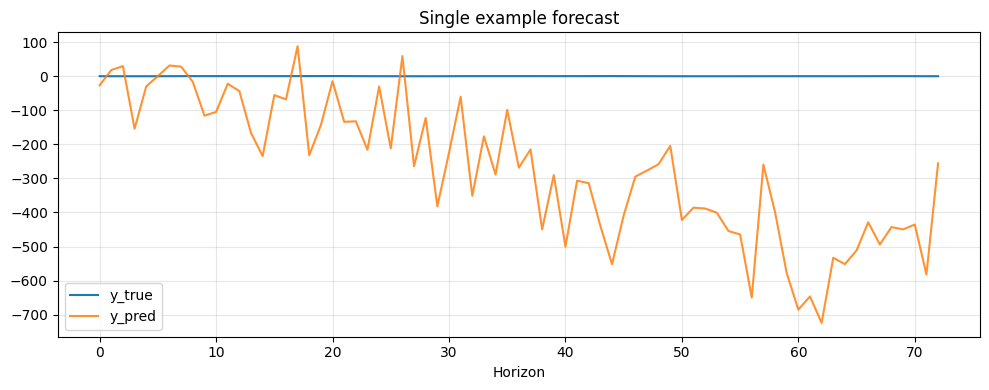

In [46]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1) Visualize a single sample
def plot_one(model, ds):
    for x, y in ds.take(1):
        yp = model(x, training=False)
        y = y.numpy(); yp = np.asarray(yp)
        y1 = y[0].squeeze()  # (H[,C]) -> (H,)
        p1 = yp[0].squeeze()
        m = min(len(y1), len(p1))
        plt.figure(figsize=(10,4))
        plt.plot(y1[:m], label='y_true')
        plt.plot(p1[:m], label='y_pred', alpha=0.85)
        plt.title('Single example forecast')
        plt.xlabel('Horizon'); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
        plt.show()
        break

# 2) Standard evaluation across the whole test set
def eval_keras(model, ds):
    # Assumes model was compiled with loss/metrics you care about
    return model.evaluate(ds, verbose=1)

# 3) Per-horizon metrics across the whole set (useful with overlapping windows)
def per_horizon_mae(model, ds):
    Yt, Yp = [], []
    for xb, yb in ds:
        yp = model(xb, training=False)
        Yt.append(yb.numpy()); Yp.append(np.asarray(yp))
    Yt = np.concatenate(Yt, axis=0)  # (N, H[,C])
    Yp = np.concatenate(Yp, axis=0)
    Yt = Yt.squeeze()  # (N, H)
    Yp = Yp.squeeze()
    mae_h = np.mean(np.abs(Yp - Yt), axis=0)  # (H,)
    return mae_h

# Example usage:
plot_one(linear, ds_linear)
# print(eval_keras(linear, ds_linear))
# mae_h = per_horizon_mae(linear, ds_linear); print('Per-horizon MAE:', mae_h)

# N1B — Série Univariada (seq_len=168, lead=48)


Objetivo
- Prever 48 horas de carga à frente com janelas de 168 horas de histórico para um único país.


Artefatos esperados
- TFRecord (Linear/MLP): data/N1B/ linear_dataset_{split}_*.tfrecord + meta.json { x_dim, y_dim }
- TFRecord (LSTM): data/N1B/ lstm_dataset_{split}_*.tfrecord + meta.json (base) { seq_len=240, lead=72, x_dim, y_dim }
- TFT (opcional): data/treinamento/tft_dataset_{split}.parquet


Modelos a comparar
- Linear, MLP, LSTM, TFT (opcional).


Métricas e checks
- MAE, RMSE, MAPE; validação de shapes e ausência de NaNs.


Visualizações sugeridas
- Barras de MAE médio por modelo; curva de erro por horizonte.


Notas
- As variantes A/B são derivadas do dataset base (240/72) reduzindo janela/horizonte na avaliação, sem retreinar.

# N1C — Série Univariada (seq_len=240, lead=72)


Objetivo
- Pré-treino/treino com a janela de 240 horas e avaliar horizonte de 72 horas.


Artefatos esperados
- TFRecord (Linear/MLP): data/N1C/ linear_dataset_{split}_*.tfrecord + meta.json { x_dim, y_dim }
- TFRecord (LSTM): data/N1C/ lstm_dataset_{split}_*.tfrecord + meta.json { seq_len=240, lead=72, x_dim, y_dim }
- TFT (opcional): data/treinamento/tft_dataset_{split}.parquet


Modelos a comparar
- Linear, MLP, LSTM, TFT (opcional).


Métricas e checks
- MAE, RMSE, MAPE; número de amostras por split; coerência entre seq_len/lead do meta e shapes efetivos.


Visualizações sugeridas
- Curva comparativa de MAE vs horizonte; top‑k modelos por MAE.


Notas
- Esta variante (C) é a base máxima de lookback e horizonte; A/B são obtidas por redução na avaliação.

# N2A — Múltiplos Países (seq_len=72, lead=24)


Objetivo
- Prever 24 horas com 72 horas de histórico, agrupando por país.


Artefatos esperados
- TFRecord (Linear/MLP): data/N2A/ linear_dataset_{split}_*.tfrecord + meta.json
- TFRecord (LSTM): data/N2A/ lstm_dataset_{split}_*.tfrecord + meta.json (base) { seq_len=240, lead=72, x_dim, y_dim }
- TFT (recomendado): data/treinamento/tft_dataset_{split}.parquet (colunas: _group_id=country, time_idx crescente por grupo, quantity_MW)


Modelos a comparar
- Linear, MLP, LSTM (podem exigir codificação/flatten por grupo);
- TFT (nativamente multi‑grupo).


Métricas e checks
- MAE/RMSE por país e globais; número de grupos; equilíbrio de amostras por grupo.


Visualizações sugeridas
- Barras de MAE por modelo; facetas por país; curva MAE vs horizonte.


Notas
- As variantes A/B/C partem do dataset base (240/72), aplicando janelas/horizontes reduzidos na avaliação.

# N2B — Múltiplos Países (seq_len=168, lead=48)


Objetivo
- Prever 48 horas com 168 horas de histórico, agrupado por país.


Artefatos esperados
- TFRecord (Linear/MLP): data/N2B/ linear_dataset_{split}_*.tfrecord + meta.json
- TFRecord (LSTM): data/N2B/ lstm_dataset_{split}_*.tfrecord + meta.json (base) { seq_len=240, lead=72, x_dim, y_dim }
- TFT (recomendado): data/treinamento/tft_dataset_{split}.parquet com `_group_id`, `time_idx`, target.


Modelos a comparar
- Linear, MLP, LSTM; TFT.


Métricas e checks
- MAE/RMSE por país e agregadas; distribuição de amostras por grupo.


Visualizações sugeridas
- Barras de MAE por modelo; linhas por horizonte; painel por país.


Notas
- Variantes A/B/C usam janelas/horizontes efetivos na avaliação; TFRecords base: 240/72.

# N2C — Múltiplos Países (seq_len=240, lead=72)


Objetivo
- Prever 72 horas com 240 horas de histórico, agrupado por país. Esta variante é a base para reuso em A/B.


Artefatos esperados
- TFRecord (Linear/MLP): data/N2C/ linear_dataset_{split}_*.tfrecord + meta.json
- TFRecord (LSTM): data/N2C/ lstm_dataset_{split}_*.tfrecord + meta.json { seq_len=240, lead=72, x_dim, y_dim }
- TFT (recomendado): data/treinamento/tft_dataset_{split}.parquet (agrupado por `_group_id`).


Modelos a comparar
- Linear, MLP, LSTM, TFT.


Métricas e checks
- MAE, RMSE, MAPE; comparação por país; checagem de time_idx e integridade por grupo.


Visualizações sugeridas
- Curva MAE vs horizonte; ranking de modelos por país e global.


Notas
- TFRecords base usam seq_len=240 e lead=72; variações A/B podem ser avaliadas reduzindo janela no dataset sem retreino.

# N3 — Robustez a Ruído (sobre N2)

Objetivo
- Medir degradação de desempenho sob ruído gaussiano nas FEATURES (teste), mantendo rótulos intactos.

Configuração
- Conjuntos: use os datasets do N2 (A/B/C).
- Intensidades: σ ∈ {0.00, 0.01, 0.03, 0.05, 0.10}.
- Aplicação:
  - TFRecords: `add_noise_features(ds, sigma, tipo='tf_record', pad_sentinel=-999.0)`.
  - TFT: `add_noise_features(tft_ds ou dataloader, sigma, tipo='tft', batch_size=..., train=False)`.

Métricas e checks
- MAE/RMSE por sigma; checar preservação de sentinela (TF) e invariância de Y.

Visualizações sugeridas
- Curvas MAE vs σ por modelo; heatmap de degradação por horizonte e sigma.

Notas
- Aplique ruído após normalização das features.
- Não altere o treino; apenas avaliação/benchmark.
